In [1]:
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [2]:
# Importing the the clean csv
from google.colab import files
data_to_load = files.upload()

Saving df_clean.csv to df_clean.csv


In [3]:
# Creating the dataframe
import io
df = pd.read_csv(io.BytesIO(data_to_load['df_clean.csv']))

In [4]:
# Looking at the rows
df.head()

,swab_type,covid19_test_results,age,high_risk_exposure_occupation,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,sys,dia,rr,sats,days_since_symptom_onset,cough,sob,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,test_name_COVID-19 PCR Test (Curative),test_name_COVID-19 Vitagene At Home Test Kit,test_name_Rapid COVID-19 PCR Test,test_name_Rapid COVID-19 Test,test_name_SARS COV 2 RNA RTPCR,test_name_SARS COV2 NAAT,test_name_SARS CoV w/CoV 2 RNA,"test_name_SARS-CoV-2 (COVID-19) by NAAT/RT-PCR/TMA, High Risk","test_name_SARS-CoV-2 (COVID-19) by NAAT/RT-PCR/TMA, Unknown Risk","test_name_SARS-CoV-2, NAA",fever2,high_risk_interactions_False,high_risk_interactions_True,high_risk_interactions_nan,ctab_False,ctab_True,ctab_nan,labored_respiration_False,labored_respiration_True,labored_respiration_nan,rhonchi_False,rhonchi_True,rhonchi_nan,wheezes_False,wheezes_True,wheezes_nan
0,0,0,15,0,0,0,0,0,0,0,0,0,37.00,74.0,123.0,80.0,17,99.0,7.063914,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
1,1,0,20,0,0,0,0,0,0,0,0,0,36.75,88.0,105.0,73.0,12,96.0,7.063914,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0
2,0,0,14,0,0,0,0,0,0,0,0,0,36.95,83.0,138.0,61.0,18,99.0,7.063914,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1
3,1,0,32,0,0,0,0,0,0,0,0,0,36.85,88.0,160.0,99.0,12,99.0,7.063914,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1
4,0,0,29,0,0,0,0,0,0,0,0,0,37.00,82.0,111.0,74.0,17,99.0,3.000000,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0


In [5]:
# Creating the X and y
features = ['age',
       'high_risk_exposure_occupation', 'diabetes', 'chd', 'htn', 'cancer',
       'asthma', 'copd', 'autoimmune_dis', 'smoker', 'temperature', 'pulse',
       'sys', 'dia', 'rr', 'sats', 'days_since_symptom_onset', 'cough', 'sob',
       'diarrhea', 'fatigue', 'headache', 'loss_of_smell', 'loss_of_taste',
       'runny_nose', 'muscle_sore', 'sore_throat',
      'fever2', 'high_risk_interactions_False',
       'high_risk_interactions_True', 'high_risk_interactions_nan',
       'ctab_False', 'ctab_True', 'ctab_nan', 'labored_respiration_False',
       'labored_respiration_True', 'labored_respiration_nan', 'rhonchi_False',
       'rhonchi_True', 'rhonchi_nan', 'wheezes_False', 'wheezes_True',
       'wheezes_nan']
X = df[features]
y = df['covid19_test_results']

In [6]:
# Train/ test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
# Get the baseline
y_test.value_counts(normalize=True)

0    0.982064
1    0.017936
Name: covid19_test_results, dtype: float64

In [8]:
# Instanite the Random Over Sampler
# Fit X and y to Random Over Sampler
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [133]:
# Instantiate the model
model = Sequential()

model.add(Dense(512, input_shape=(X_over.shape[1], ), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu')) 
model.add(Dense(1, activation='sigmoid')) 

In [134]:
# Complie the model
model.compile(loss='bce', optimizer='RMSProp', metrics=['acc'])

In [137]:
# Add early stopping
es = EarlyStopping(patience=3)

In [138]:
# Fit the model to the Random Under Sampler X and y
results = model.fit(X_over, y_over, 
                   epochs=25,
                   validation_data=(np.asarray(X_test).astype(np.float32), np.asarray(y_test).astype(np.float32)),
                   verbose=1, # No output will be printed!
                   batch_size=256, callbacks=[es])

Epoch 1/25
564/564 [==============================] - 5s 10ms/step - loss: 0.5842 - acc: 0.6950 - val_loss: 0.6154 - val_acc: 0.5889
Epoch 2/25
564/564 [==============================] - 6s 10ms/step - loss: 0.5608 - acc: 0.7140 - val_loss: 0.5497 - val_acc: 0.7542
Epoch 3/25
564/564 [==============================] - 5s 9ms/step - loss: 0.5484 - acc: 0.7232 - val_loss: 0.5079 - val_acc: 0.7933
Epoch 4/25
564/564 [==============================] - 5s 9ms/step - loss: 0.5423 - acc: 0.7277 - val_loss: 0.4798 - val_acc: 0.8453
Epoch 5/25
564/564 [==============================] - 5s 9ms/step - loss: 0.5351 - acc: 0.7308 - val_loss: 0.5412 - val_acc: 0.7271
Epoch 6/25
564/564 [==============================] - 5s 9ms/step - loss: 0.5289 - acc: 0.7360 - val_loss: 0.7224 - val_acc: 0.6093
Epoch 7/25
564/564 [==============================] - 5s 9ms/step - loss: 0.5266 - acc: 0.7374 - val_loss: 0.3764 - val_acc: 0.8722
Epoch 8/25
564/564 [==============================] - 5s 9ms/step - loss: 

In [139]:
# Check the MSE on the testing data
model.evaluate(np.asarray(X_test).astype(np.float32), np.asarray(y_test).astype(np.float32))

574/574 [==============================] - 1s 1ms/step - loss: 0.4918 - acc: 0.8080


[0.49181124567985535, 0.8080466389656067]

In [140]:
# Prediciting the X_test and creating y_pred
y_pred = model.predict_classes(np.asarray(X_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [141]:
# Creating y_true from y_test 
y_true=np.asarray(y_test)

In [142]:
# Looking at the confusion matrix 
print(confusion_matrix(y_true,y_pred))

[[14579  3435]
 [   86   243]]


In [143]:
# Unraveling the confusion matrix 
tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()

In [144]:
# True negative
tn

14579

In [145]:
# False positive 
fp

3435

In [146]:
# False negative 
fn

86

In [147]:
# True positive
tp

243

In [148]:
# Recall score 
metrics.recall_score(y_true=y_true, y_pred=y_pred)

0.7386018237082067

In [149]:
# F1- score 
metrics.f1_score(y_true=y_true, y_pred=y_pred)

0.12128774644372349

In [150]:
# Precision score 
metrics.precision_score(y_true=y_true, y_pred=y_pred)

0.06606851549755302

In [151]:
# Looking at the results dictionary 
results.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

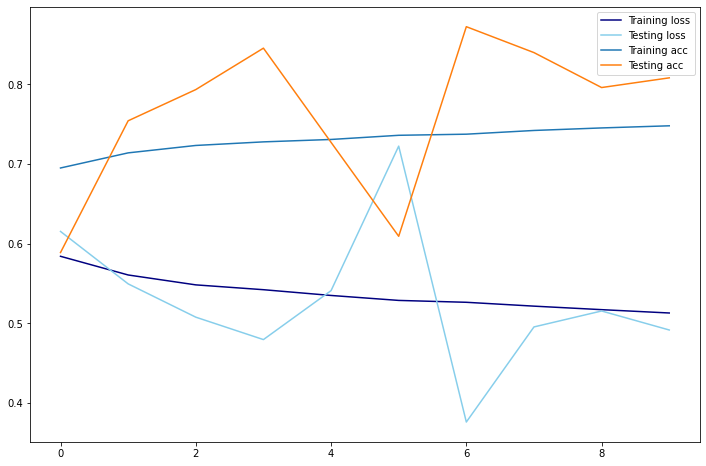

In [152]:
# Graphing the Loss and Accuracy from the results 
train_loss = results.history['loss']
test_loss = results.history['val_loss']
train_acc = results.history['acc']
test_acc = results.history['val_acc']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.plot(train_acc, label='Training acc')
plt.plot(test_acc, label='Testing acc')
plt.legend();